In [1]:
import numpy as np
from os import listdir
from os.path import isfile, join
import sklearn.metrics as skmetrics
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, RocCurveDisplay


In [2]:
data_path = "./messages"
jobs_count = 11
cv_count = 10

In [3]:
def read_file(filename):
    with open(filename, "r") as f:
        subject = f.readline().split()[1:]
        f.readline()
        body = f.readline().split()
        distinct_words = subject + body
        is_spam = "spmsg" in filename
        return np.array(distinct_words), int(is_spam)

In [4]:
def read_part(num):
    dirname = data_path + "/part" + str(num)
    files = [dirname + "/" + f for f in listdir(dirname) if isfile(join(dirname, f))]
    data = map(read_file, files)
    unziped_data = list(zip(*data))
    return list(unziped_data[0]), list(unziped_data[1])

In [5]:
def read_all_parts():
    X = []
    y = []
    for i in range(1):
        cur_X, cur_y = read_part(i + 1)
        X.extend(cur_X)
        y.extend(cur_y)
    return np.array(X, dtype=object), np.array(y)

In [6]:
X_data, y_data = read_all_parts()

In [7]:
def n_gramm(words, n):
    return set(tuple(words[i:(i + n)]) for i in range(len(words) - n + 1))



class Bayes(BaseEstimator):
    def __init__(self, alpha=1, n=1, lambdas=None):
        if lambdas is None:
            lambdas = [1, 1]
        self.alpha = alpha
        self.n = n
        self.lambdas = lambdas
        self.classes_cnt = len(self.lambdas)
        self.classes_prob = None
        self.words_prob = None
        self.distinct_words = None

    def fit(self, X, y):
        self.classes_prob = np.zeros((self.classes_cnt, 2), dtype=int)
        self.distinct_words = np.zeros(self.classes_cnt, dtype=int)
        self.words_prob = [{} for _ in range(self.classes_cnt)]

        default_word_prob = np.array([self.alpha, 0], dtype=int)
        for i in range(X.shape[0]):
            cur_words = X[i]
            cur_class = y[i]
            for word in n_gramm(cur_words, self.n):
                self.words_prob[cur_class].setdefault(word, default_word_prob)
                self.words_prob[cur_class][word][0] += 1
            self.classes_prob[cur_class][0] += 1

        for cur_class in range(self.classes_cnt):
            distinct = len(self.words_prob[cur_class])
            self.distinct_words[cur_class] = distinct
            self.classes_prob[cur_class][1] = self.classes_cnt
            for word in self.words_prob[cur_class].keys():
                self.words_prob[cur_class][word][1] = self.classes_prob[cur_class][0] + distinct * self.alpha

    def get_prob(self, cur_class, word):
        zero_numinator = self.alpha
        zero_denuminator = self.classes_prob[cur_class][0] + self.alpha * self.distinct_words[cur_class]
        zero_prob = np.array([zero_numinator, zero_denuminator])
        return self.words_prob[cur_class].get(word, zero_prob)

    def predict_one(self, cur_msg):
        metrics = np.log(self.classes_prob)
        cur_words = n_gramm(cur_msg, self.n)
        for cur_class in range(self.classes_cnt):
            metrics[cur_class][0] += math.log(self.lambdas[cur_class])
            for word in cur_words:
                metrics[cur_class] += np.log(self.get_prob(cur_class, word))
        return np.argmax(metrics[0] - metrics[1])

    def predict(self, X):
        return np.vectorize(self.predict_one)(X)

In [8]:
def get_score(y_true, y_pred):
    tmp = y_true - y_pred
    if -1 in tmp:
        return -100000000
    else:
        return skmetrics.accuracy_score(y_true, y_pred)


my_scorer = skmetrics.make_scorer(get_score)

In [9]:
parameters_acc = {
    'alpha': [10 ** i for i in range(-10, -5)],
    'n'    : [1,2,3]
}
clf_acc = GridSearchCV(Bayes(), parameters_acc, cv=cv_count, n_jobs=jobs_count, scoring='accuracy')
clf_acc.fit(X_data, y_data)

GridSearchCV(cv=10, estimator=Bayes(lambdas=[1, 1]), n_jobs=11,
             param_grid={'alpha': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06],
                         'n': [1, 2, 3]},
             scoring='accuracy')

In [10]:
print(clf_acc.best_params_)
print(clf_acc.best_score_)

{'alpha': 1e-10, 'n': 1}
0.9545454545454547


In [11]:
parameters_f1 = {
    'alpha': [10 ** i for i in range(-10, -5)],
    'n'    : [1,2,3]
}
clf_f1 = GridSearchCV(Bayes(), parameters_f1, cv=cv_count, n_jobs=jobs_count, scoring='f1')
clf_f1.fit(X_data, y_data)

GridSearchCV(cv=10, estimator=Bayes(lambdas=[1, 1]), n_jobs=11,
             param_grid={'alpha': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06],
                         'n': [1, 2, 3]},
             scoring='f1')

In [12]:
print(clf_f1.best_params_)
print(clf_f1.best_score_)

{'alpha': 1e-10, 'n': 1}
0.9511111111111111


In [13]:
parameters_acc_no_fp = {
    'alpha': [1e-7],
    'n'    : [1, 2, 3],
    'lambdas': [[10 ** i, 1] for i in range(40)],
}
clf_acc_no_fp = GridSearchCV(Bayes(), parameters_acc_no_fp, cv=cv_count, n_jobs=jobs_count, scoring=my_scorer)
clf_acc_no_fp.fit(X_data, y_data)

GridSearchCV(cv=10, estimator=Bayes(lambdas=[1, 1]), n_jobs=11,
             param_grid={'alpha': [1e-07],
                         'lambdas': [[1, 1], [10, 1], [100, 1], [1000, 1],
                                     [10000, 1], [100000, 1], [1000000, 1],
                                     [10000000, 1], [100000000, 1],
                                     [1000000000, 1], [10000000000, 1],
                                     [100000000000, 1], [1000000000000, 1],
                                     [10000000000000, 1], [100000000000000, 1],
                                     [1000000000000000, 1],
                                     [10000000000000000, 1],
                                     [100000000000...
                                     [100000000000000000000, 1],
                                     [1000000000000000000000, 1],
                                     [10000000000000000000000, 1],
                                     [100000000000000000000000, 1],
     

In [14]:
print(clf_acc_no_fp.best_params_)
print(clf_acc_no_fp.best_score_)

{'alpha': 1e-07, 'lambdas': [100000000000000000000000000000000000, 1], 'n': 1}
0.9272727272727274


In [15]:
parameters_chart = {
    'alpha': [1e-7],
    'n'    : [1, 2, 3],
    'lambdas': [[10 ** i, 1] for i in range(40)],
}
clf_chart = GridSearchCV(Bayes(), parameters_chart, cv=cv_count, scoring=['accuracy', 'f1'], refit='f1', n_jobs=jobs_count)
clf_chart.fit(X_data, y_data)

GridSearchCV(cv=10, estimator=Bayes(lambdas=[1, 1]), n_jobs=11,
             param_grid={'alpha': [1e-07],
                         'lambdas': [[1, 1], [10, 1], [100, 1], [1000, 1],
                                     [10000, 1], [100000, 1], [1000000, 1],
                                     [10000000, 1], [100000000, 1],
                                     [1000000000, 1], [10000000000, 1],
                                     [100000000000, 1], [1000000000000, 1],
                                     [10000000000000, 1], [100000000000000, 1],
                                     [1000000000000000, 1],
                                     [10000000000000000, 1],
                                     [100000000000...
                                     [100000000000000000000, 1],
                                     [1000000000000000000000, 1],
                                     [10000000000000000000000, 1],
                                     [100000000000000000000000, 1],
     

In [16]:
xx = list(map(lambda t: t[0], parameters_chart['lambdas']))
yy_acc = clf_chart.cv_results_["mean_test_accuracy"]
yy_f1 = clf_chart.cv_results_["mean_test_f1"]

In [17]:
def draw_metric_lambda(n=1, cur=1):
    plt.figure(figsize=(16, 9))
    plt.grid(linestyle='--')
    plt.semilogx(xx, [yy_acc[i * n + cur - 1] for i in range(int(len(yy_acc) / n))],
                 linestyle='-', marker='.', color='r', label='Accuracy')

    plt.semilogx(xx, [yy_f1[i * n + cur - 1] for i in range(int(len(yy_acc) / n))],
                 linestyle='-', marker='.', color='b', label='F1 score')

    plt.xlabel('Шраф за легитимные сообщения')
    plt.ylabel('Значение метрики')
    plt.legend()
    plt.show()

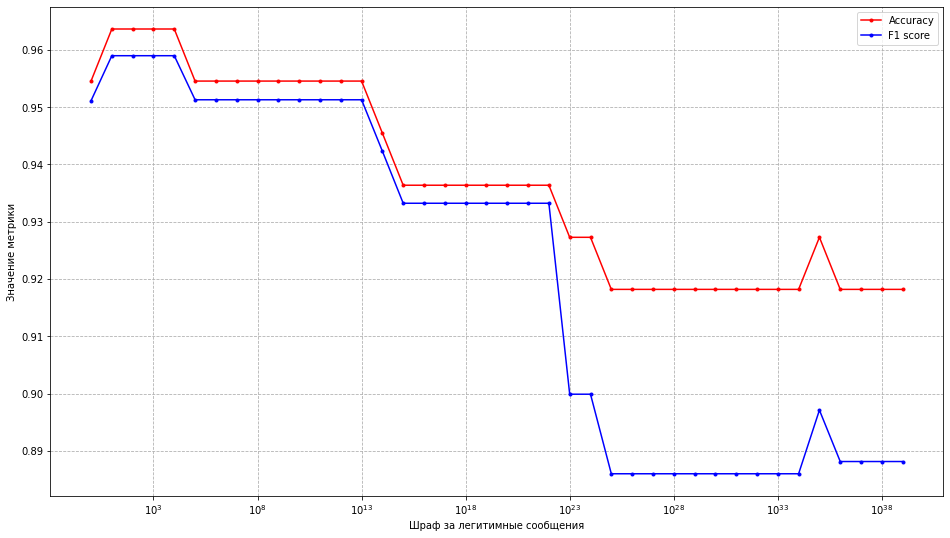

In [18]:
draw_metric_lambda(3, 1)

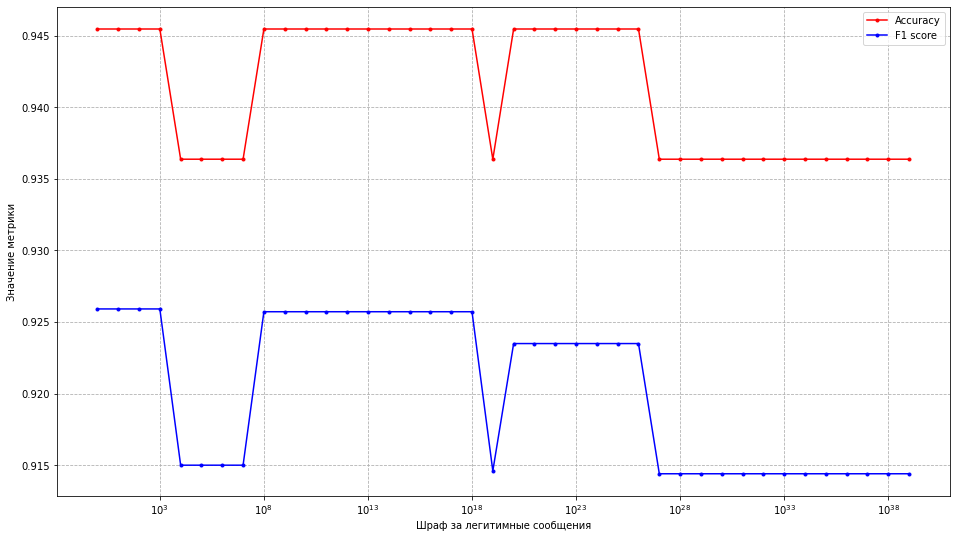

In [19]:
draw_metric_lambda(3, 2)

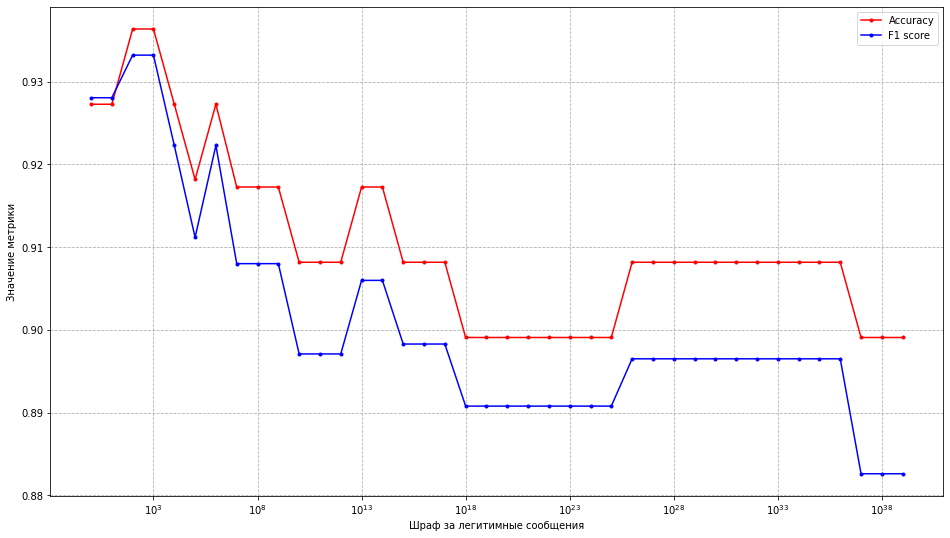

In [20]:
draw_metric_lambda(3, 3)

In [21]:
def draw_roc(alpha, n=1, lambdas=None):
    if lambdas is None:
        lambdas = [1, 1]
    X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.33, random_state=42)

    bay = Bayes(alpha, n, lambdas)
    bay.fit(X_train, y_train)

    fpr, tpr, thresholds = roc_curve(y_test, bay.predict(X_test))
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='example estimator')
    display.plot()
    plt.show()

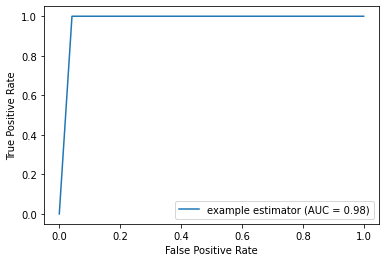

In [22]:
draw_roc(1e-20, 1)

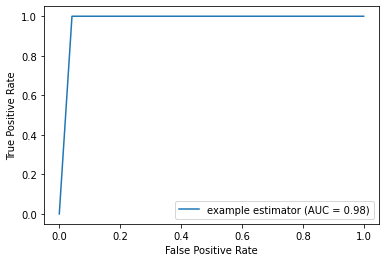

In [23]:
draw_roc(1e-20, 2)

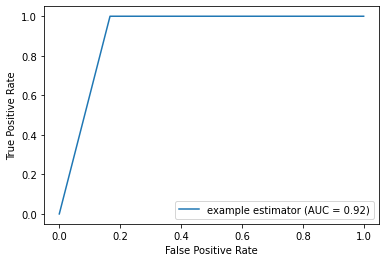

In [24]:
draw_roc(1e-20, 3)

In [1]:
draw_roc(1e-20, 1, [10**35, 1])


NameError: name 'draw_roc' is not defined

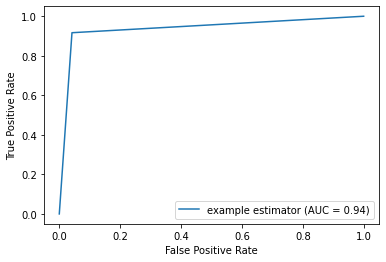

In [26]:
draw_roc(1e-20, 2, [10**35, 1])

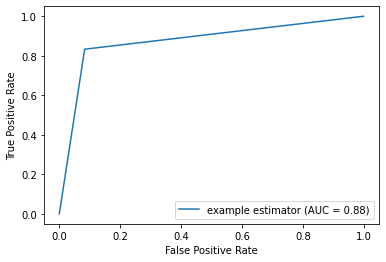

In [27]:
draw_roc(1e-20, 3, [10**35, 1])